<a href="https://colab.research.google.com/github/NatyEsquenazi/Data-Visualization/blob/main/Copy_of_Clase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('gapminder')
install.packages('socviz')
library(tidyverse)
library(gapminder)
library(socviz)

# Mostrando los números correctos
## Objetivos
- Aprender nuevos tipos de gráficos (nuevas `geoms_`)
- Entender algunas funciones "bajo el capot" de `ggplot`
- Mejorar la escritura de código

> Como ya dijimos: escribir código es una actividad frustante. Casi nunca funciona como queremos la primera vez que lo escribimos. Es lo mismo que aprender un idioma nuevo. Por eso es importante tratar de escribir código desde cero y no copiar y pegar los ejemplos. Da una idea mucho mejor de cómo funciona la sintaxis del lenguaje, dónde es probable que cometa errores y qué hace la computadora cuando eso sucede.

Ya vimos un error muy común en `ggplot`: setear de forma incorrecta una `aes()` como una constante en lugar de asignarla a una variable. Vamos a ver otras características que pueden generar problemas: 
- cómo decirle a `ggplot` más sobre la estructura interna de sus datos (agrupación), 
- cómo dividir sus datos en partes para una gráfica (facetado) y 
- cómo hacer que ggplot realice algunos cálculos o resuma sus datos antes de producir la trama (transformar). 


## 1. La gramática, la sintaxis y el sentido
Cuando escribimos código `ggplot` estamos tratando de "decir" algo visualmente. Por lo general, se necesitan varias iteraciones para decir exactamente lo que quiere decir. Esto es más que una metáfora aquí. Ya charlamos que `ggplot` está basado en una "gramática de gráficos": un conjunto de reglas para producir gráficos a partir de datos, tomando fragmentos de datos y mapeándolos a objetos geométricos (como puntos y líneas) que tienen atributos estéticos (como posición, color y tamaño), junto con otras reglas para transformar los datos. si es necesario (por ejemplo, a una línea suavizada), ajustando las escalas (por ejemplo, a una escala logarítmica).

Algunas de estas tareas son parte de `ggplot` propiamente dicho, por lo que aprenderemos más sobre cómo las `geoms`, con la ayuda de sus funciones estadísticas asociadas, pueden actuar sobre los datos antes de graficarlos. Como también veremos, si bien es posible realizar muchas transformaciones directamente en `ggplot`, puede haber formas más convenientes de abordar la misma tarea.

Importante: al igual que otras reglas de sintaxis, la gramática limita la estructura de lo que se puede decir en el idioma `ggplot`, pero no hace que lo que se dice tenga sentido. Permite producir "oraciones" largas que comienzan con asignaciones de datos a elementos visuales y agregan cláusulas sobre qué tipo de gráfico es, cómo se escalan los ejes, etc. Pero estas oraciones pueden confundirse fácilmente. 

A veces, el código no producirá un gráfico debido a algún error de sintaxis en R. Olvidará un signo `+` entre las funciones `geom_` o habrá un paréntesis perdido en algún lugar. En esos casos, R se quejará (quizás de manera opaca) de que algo salió mal. 

En otras ocasiones, el código producirá con éxito un gráfico, pero no va a ser lo que esperábamos ver. A veces, los resultados se verán realmente extraños. [Aquí hay una curiosa galería de errores accidentales en gráficos de R.](https://accidental-art.tumblr.com/)

En esos casos, lo más probable es que le hayamos dado a `ggplot` una serie de instrucciones gramaticalmente correctas que no tienen sentido de alguna manera o que han torcido accidentalmente lo que queríamos decir.

#2. Datos agrupados: la estética (`aes()`) `group=`
Volvamos a nuestro dataset de Gapminder. Queremos hacer un gráfico de la trayectoria de la expectativa de vida a lo largo del tiempo para cada país. Mapeamos `year` a `x` y `lifeExp` a `y`. Miramos rápidamente [la documentación de ggplot](https://ggplot2.tidyverse.org/reference/geom_path.html) y vemos que `geom_line()` sirve para dibujar líneas que conecten las observaciones:

In [ ]:
p <- ggplot(data = gapminder,
            mapping = aes(x = year,
                          y = lifeExp))
p + geom_line() 

Ok. Algo salió mal. `ggplot` hace un intento de adivinar cuál es la estructura de los datos que le pasamos en el mapeo. Pero puede fallar. Por ejemplo, no se da cuenta de que los datos están agrupados por país. Tenemos que hacerlo explícito.

Como no lo hicimos, `geom_line()` intenta unir todas las líneas para cada año en particular en el orden en que aparecen en el conjunto de datos. Comienza con una observación de 1952 en la primera fila de los datos. No sabe que esto pertenece a Afganistán. En lugar de ir a Afganistán en 1953, descubre que hay una serie de observaciones de 1952, por lo que une todas las que aparecen en primer lugar, alfabéticamente por país, hasta la observación de 1952 que pertenece a Zimbabwe. Luego pasa a la primera observación del año siguiente, 1957, lo que habría funcionado si solo hubiera un país en el conjunto de datos.

El resultado no tiene sentido cuando se traza. Cuando ggplot realiza con éxito un gráfico pero el resultado parece una locura, la razón es casi siempre que algo ha salido mal en el mapeo entre los datos y la estética de la `geom` que se está utilizando.

En este caso, podemos usar la estética de grupo (`group`) para decirle a ggplot explícitamente sobre esta estructura a nivel de país.

In [ ]:
## Todos los datos de expectativa de vida, para todos los años, para todos los paises 
p <- ggplot(data = gapminder,
            mapping = aes(x = year,
                          y = lifeExp))
p + geom_line(aes(group=country)) # Cada linea es un pais (unidad de analisis)

El gráfico todavía es bastante fiero, pero muestra los datos correctamente, y cada línea representa la trayectoria de un país a lo largo del tiempo. El gigantesco valor atípico es Kuwait, en caso de que esté interesado.

La estética `group` generalmente solo es necesaria cuando la información de agrupación que necesita informar a `ggplot` no está incorporada en las variables que se asignan. Por ejemplo, cuando estábamos trazando los puntos por continente, mapear `color=continent` fue suficiente para obtener la respuesta correcta, porque `continent` ya es una variable categórica, por lo que la agrupación es clara. Sin embargo, al mapear `x=year`, no hay información en la variable año en sí para que `ggplot` sepa que está agrupada por país con el fin de trazar líneas con ella. Así que tenemos que decirlo explícitamente.

## 3. Facetar para hacer múltiples gráficos

El gráfico que acabamos de hacer tiene muchas líneas. Si bien la tendencia general es más o menos clara, parece muy desordenada y poco legible. 

Una opción es facetar los datos por alguna tercera variable, repitiendo el gráfico original para cada cateogría de esa tercera varible. Esta es una técnica muy poderosa que permite presentar una gran cantidad de información de manera compacta y de una manera uniformemente comparable. Se dibuja un panel separado para cada valor de la variable de facetado. Las facetas no son una `geom_`, sino una forma de organizar una serie de `geoms`. En este caso tenemos disponible la variable `continent`. Usaremos `facet_wrap()` para dividir nuestra parcela por continente.

La función `facet_wrap()` puede tomar una serie de argumentos, pero el más importante es el primero, que se especifica usando la sintaxis de "fórmula" de R, que usa el carácter `~`. Las facetas suelen ser una fórmula unilateral. La mayoría de las veces, solo queremos una sola variable en el lado derecho de la fórmula. Pero podemos acomodar más de una variable: sería el equivalente gráfico de las tablas de contingencia de múltiples factores. Para nuestro primer ejemplo, solo usaremos un solo término en nuestra fórmula, que es la variable por la que queremos dividir los datos: `facet_wrap(~continente)`.

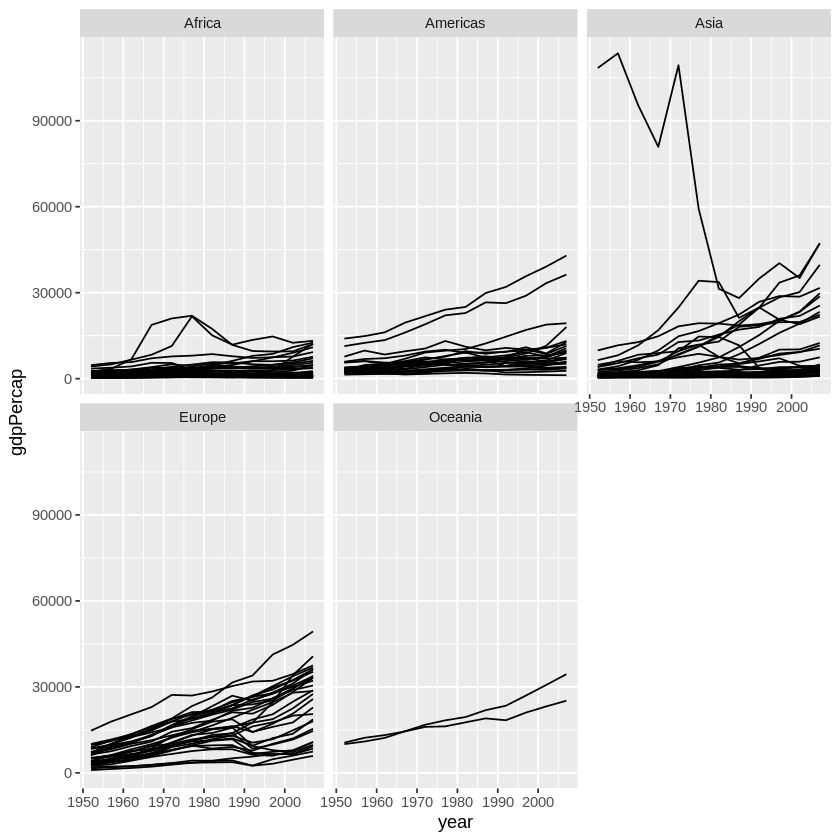

In [ ]:
p <- ggplot(data = gapminder,
            mapping = aes(x = year,
                          y = gdpPercap))
p + geom_line(aes(group = country)) + 
    facet_wrap(~ continent)

Cada faceta está etiquetada en la parte superior. El diseño general minimiza la duplicación de etiquetas de eje y otras escalas. Todavía podemos incluir otras `geoms` como antes, y se colocarán en capas dentro de cada faceta. También podemos usar el argumento `ncol` en `facet_wrap()` para controlar el número de columnas usadas para diseñar las facetas. 

Debido a que solo tenemos cinco continentes, vale la pena ver si podemos colocarlos en una sola fila (lo que significa que tendremos cinco columnas). Además, podemos agregar un poco más suave y algunas mejoras cosméticas que hacen que el gráfico sea un poco más efectivo. 

En particular, haremos que las tendencias del país sean de un color gris claro. Necesitamos escribir un poco más de código para que todo esto suceda.

In [ ]:
p <- ggplot(data = gapminder, mapping = aes(x = year, y = gdpPercap))
p + geom_line(color="gray70", aes(group = country)) +
    geom_smooth(size = 1.1, method = "loess", se = FALSE) +
    scale_y_log10(labels=scales::dollar) +
    facet_wrap(~ continent, ncol = 5) +
    labs(x = "Year",
         y = "GDP per capita",
         title = "GDP per capita on Five Continents") +
    theme_minimal()

<img src="https://socviz.co/dataviz-pdfl_files/figure-html4/ch-04-gapminder-04-1.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;"/>

Podríamos haber facetado por país, lo que habría hecho superfluo el mapeo de grupos. Pero eso haría casi ciento cincuenta paneles. 

Este gráfico reúne 

- un mapeo estético de las variables `x` e `y`, 
- una estética de agrupación: `group=country`, 
- dos `geoms`: `geom_line()` y `geom_smooth()`, 
- un eje `y` transformado logarítmicamente :`scale_y_log()` 
- con etiquetas apropiadas: `labels=scales::dollar`, 
- una variable de facetado: `facet_wrap(~continent)` y
- un eje etiquetas y un título: `labs(...)`

La función `facet_wrap()` se utiliza mejor cuando desea una serie de pequeños múltiplos basados ​​en una única variable categórica. Sus paneles se colocarán en orden y luego se envolverán en una cuadrícula. Se puede especificar el número de filas o el número de columnas en el diseño resultante. Las facetas pueden ser más complejas que esto. 

Por ejemplo, es posible  realizar una clasificación cruzada de algunos datos mediante dos variables categóricas. En ese caso, deberíamos probar `facet_grid()` en su lugar. Esta función presentará su trama en una verdadera disposición bidimensional, en lugar de una serie de paneles envueltos en una cuadrícula.

Para ver la diferencia, introduzcamos `gss_sm`, un nuevo dataset. Es un pequeño subconjunto de las preguntas de la Encuesta Social General de 2016 de Estados Unidos (GSS). El GSS es una encuesta de larga duración de adultos estadounidenses que pregunta sobre una variedad de temas de interés para los científicos sociales. 

Usaremos los datos del GSS de una manera un poco ingenua. En particular, no consideraremos los pesos de las muestras. Si recordamos, los datos de `gapminder` consisten en variables continuas medidas dentro de los países por año. Medidas como el `gdpPercap` pueden tomar cualquier valor en un amplio rango y varían sin problemas. La única variable de agrupación categórica es `continent`. Es una variable categórica no ordenada o nominal. Cada país pertenece a un continente, pero los continentes en sí no tienen un orden natural.

En el trabajo científico social, especialmente cuando se analizan datos de encuestas a nivel individual, a menudo trabajamos con datos categóricos de varios tipos. A veces, las categorías están desordenadas, como ocurre con la etnia o el sexo. 

Pero también pueden ordenarse, como cuando mido el nivel más alto de educación alcanzado en una escala que va desde la escuela primaria hasta el posgrado.  Las preguntas de opinión se pueden hacer en términos de sí o no, o en una escala de cinco o siete puntos con un valor neutral en el medio. 

Mientras tanto, muchas medidas numéricas, como el número de hijos, todavía pueden tomar valores enteros dentro de un rango relativamente estrecho. En la práctica, estos también pueden tratarse como variables categóricas ordenadas que van desde cero hasta algún valor codificado en la parte superior, como "Seis o más". Incluso las medidas adecuadamente continuas, como los ingresos, rara vez se informan en dólares y, a menudo, solo se pueden obtener como categorías ordenadas. 

Los datos GSS en `gss_sm` contienen muchas medidas de este tipo. 


In [ ]:
glimpse(gss_sm)

Vamos a hacer un diagrama de dispersión suavizado de la relación entre la edad del encuestado y el número de hijos que tiene. En `gss_sm`, la variable `childs` es un conteo numérico de los hijos del encuestado. (También hay una variable llamada `kids` que es la misma medida, pero su clase es un factor ordenado en lugar de un número). 

Luego, facetaremos esta relación por `sex` y `race` del encuestado. Usamos la notación de fórmula de R en la función `facet_grid` para facetar sexo y raza.

In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = age, y = childs))
p + geom_point(alpha = 0.2) +
    geom_smooth() +
    facet_grid(sex ~ race)

Este tipo de diseños "multipanel" es especialmente efectivo cuando se usa para resumir la variación continua (como en un diagrama de dispersión) entre dos o más variables categóricas.

Si podemos ordenar las categorías (y por lo tanto los paneles) de alguna manera que tenga sentido. No estamos limitados a la comparación bidireccional. 

También se pueden agregar más variables categóricas a la fórmula (por ejemplo, `sexo ~ raza + grado`) para gráficos multidireccionales más complejos. 

Sin embargo, pueden volverse gráficos muy complicados muy rápido.

---
### ACTIVIDAD

¿Qué otro gráfico usando facetados podrían hacer con `gss_sm`?

---

## 4. Gráficos de barras

Vamos a introducir una nueva `geom_`: barplots o gráficos de barra. Son, simplemente, gráficos en los que la altura de la barra es proprocional a la frecuencia de la categoría.

In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = bigregion))
p + geom_bar()

Aquí especificamos solo un mapeo, `aes(x = bigregion)`. 

El gráfico de barras producido nos da un recuento del número de observaciones (individuales) en el conjunto de datos por región de los Estados Unidos. Esto parece sensato.

Pero hay una variable del eje `y` aquí, cuenta, que no está en los datos. Ha sido calculado para nosotros. Detrás de escena, `geom_bar` llamó a la función `stat_` predeterminada asociada a ella,` stat_count ()`. Esta función calcula  dos nuevas variables, `count` y `prop` (abreviatura de proporción): `count` es la que usa` geom_bar()` por defecto. 

Vamos a volver sobre la forma en que podemos calcular proporciones...

Fuera de esto, `geom_bar` tiene algunos mapeos conocidos: `color` y `fill`. Veamos otra variable del dataset:


In [ ]:
table(gss_sm$religion)

In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = religion, color = religion))
p + geom_bar()

p <- ggplot(data = gss_sm,
            mapping = aes(x = religion, fill = religion))
p + geom_bar()

Al hacer esto, hemos mapeado dos estéticas a la misma variable. Tanto `x` como `fill` se asignan a la `religion`. No hay nada malo en esto. 

Sin embargo, estos siguen siendo dos mapeos separados, por lo que obtienen dos escalas separadas. El valor predeterminado es mostrar una leyenda para la variable de color. Esta leyenda es redundante, porque las categorías de religión ya están separadas en el eje `x`. 

En su uso más simple, la función `guides()` controla si aparece o no información de guía sobre un mapeo en particular. Si establecemos `guides(fill = FALSE)`, la leyenda se elimina, lo que indica que no es necesario que se muestre al espectador de la figura ninguna información de orientación sobre este mapeo. 

Establecer la guía para algunos mapeos en FALSO solo tiene efecto si hay una leyenda para desactivar para empezar. Intentar `x = FALSE` o `y = FALSE` no tendrá ningún efecto, ya que estas asignaciones no tienen guías o leyendas adicionales separadas de sus escalas. Es posible desactivar las escalas `x` e `y` por completo, pero esto se hace a través de una función diferente, una de la familia `scale_`.

In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = religion, fill = religion))
p + geom_bar() + guides(fill=FALSE)

---
### ACTIVIDAD

Eliminen la leyenda del primer plot

---

### 4.1 Gráficos apilados
Otro uso posible de la estética `fill` con` geom_bar()` es la clasificación cruzada de dos variables categóricas. Este es el equivalente gráfico de una tabla de frecuencias de recuentos o proporciones. 

Usando los datos de GSS, por ejemplo, podríamos querer examinar la distribución de preferencias religiosas dentro de diferentes regiones de los Estados Unidos. Veamos primero cómo hacerlo usando solo `ggplot`.


In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = bigregion, fill = religion))
p + geom_bar()

La salida predeterminada de` geom_bar()` es un gráfico de barras apiladas, con recuentos en el eje `y` (y por lo tanto también cuenta dentro de los segmentos apilados de las barras). La `region` del país está en el eje `x`, y los recuentos de preferencia religiosa se apilan dentro de las barras. 

¿Qué se ve en esta tabla? ¿Qué problemas perceptuales puede haber?

Una opción alternativa es establecer el argumento de posición en `fill`. 

In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = bigregion, fill = religion))
p + geom_bar(position = "fill")

Variando el argumento `position` podemos "desapilar" las barras:

In [ ]:
p <- ggplot(data = gss_sm,
            mapping = aes(x = bigregion, fill = religion))
p + geom_bar(position = "dodge")

¿Pero qué pasó acá?

Vemos que pedirle a `geom_bar()` que haga todo el trabajo es poco claro y propenso a errores. La forma más simple de trabajar es calcular previamente la tabla que vamos a darle como input a `ggplot`.

In [ ]:
rel_by_region <- gss_sm %>%
  group_by(bigregion, religion) %>%
  summarise(n = n()) %>%
  mutate(prop = n/sum(n),
         pct = round((prop*100), 0))

¿Qué hicimos acá?

- Creamos un objeto (`rel_by_region`) que toma como resultado el output de las siguientes acciones:
- empezamos con `gss_sm`
- agrupamos por `bigregion` y `religion` => `group_by(bigregion, religion)`
- calculamos el conteo de casos =>  `summarise(n = n())`
- creamos dos variables nuevas: `prop` (la proporción de casos) y `pct` (el porcentaje) => `mutate(prop = n/sum(n), pct = round((prop*100), 0))`

Podemos chequear que los cálculos estén correctos:

In [ ]:
rel_by_region %>% group_by(bigregion) %>%
    summarize(total = sum(pct))

Esto luce bien. Como antes, ahora que estamos trabajando directamente con valores porcentuales en una tabla de resumen, podemos usar `geom_col() `en lugar de `geom_bar()`.


In [ ]:
p <- ggplot(rel_by_region, aes(x = bigregion, y = pct, fill = religion))
p + geom_col(position = "dodge2") +
    labs(x = "Region",y = "Percent", fill = "Religion") +
    theme(legend.position = "top")

Usamos un argumento de posición diferente aquí, `"dodge2`" en lugar de `"dodge"`. Esto pone las barras una al lado de la otra. 

Cuando se trata de valores precalculados en `geom_col()`, la posición predeterminada es hacer un gráfico de columnas apiladas proporcionalmente. Si usa `dodge`, se apilarán dentro de columnas, pero el resultado se leerá incorrectamente. El uso de `dodge2` coloca las subcategorías (`religion`) una al lado de la otra dentro de los grupos (`bigregion`).

¿Qué problemas ven en este gráfico? ¿Cómo podemos mejorarlo?

Como regla general, los gráficos esquivados se pueden expresar de manera más clara como gráficos facetados. Esto elimina la necesidad de una leyenda `y`, por lo tanto, simplifica la lectura del gráfico. También presentamos una nueva función. Si asignamos la religión al eje `x`, las etiquetas se superpondrán y se volverán ilegibles. 

Es posible ajustar manualmente las etiquetas de las marcas de verificación para que se impriman en ángulo, pero tampoco es tan fácil de leer. Tiene más sentido poner las religiones en el eje `y` y las puntuaciones porcentuales en el eje `x`. Debido a la forma en que` geom_bar() `funciona internamente, simplemente intercambiar el mapeo `x` e `y` no funcionará. (Prueben y vean). 

Lo que hacemos en su lugar es transformar el sistema de coordenadas en el que se grafican los resultados, de modo que los ejes xey se inviertan. Hacemos esto con `coord_flip()`.

In [ ]:
p <- ggplot(rel_by_region, aes(x = religion, y = pct, fill = religion))
p + geom_col(position = "dodge2") +
    labs(x = NULL, y = "Percent", fill = "Religion") +
    guides(fill = FALSE) + 
    coord_flip() + 
    facet_grid(~ bigregion)

Para la mayoría de las gráficas, el sistema de coordenadas es cartesiano y muestra las gráficas en un plano definido por un eje `x` y un eje `y`. La función `coord_cartesian()` gestiona esto, pero no necesitamos llamarlo. 

La función `coord_flip()` cambia los ejes `x` e `y` después de realizar el gráfico. No reasigna variables a la estética. En este caso, `religion` todavía se asigna a `x` y `pct` a `y`. Debido a que los nombres de las religiones no necesitan una etiqueta de eje para ser entendidos, establecemos `x = NULL` en la llamada a `labs ()`.


## 5. Histogramas y density plots

Diferentes geoms transforman los datos de diferentes maneras, pero el vocabulario de `ggplot` para ellos es consistente. Podemos ver transformaciones similares en funcionamiento al resumir una variable continua usando un histograma, por ejemplo. Un histograma es una forma de resumir una variable continua dividiéndola en segmentos o "contenedores" y contando cuántas observaciones se encuentran dentro de cada contenedor. En un gráfico de barras, se nos dan las categorías que ingresamos (por ejemplo, regiones del país o afiliación religiosa). Con un histograma, tenemos que decidir con qué precisión agrupar los datos.

Por ejemplo, `ggplot` incluye un dataset, `midwest`, que contiene información sobre condados en varios estados del medio oeste de EE. UU. 

In [ ]:
head(midwest)

Los condados varían en tamaño, por lo que podemos hacer un histograma que muestre la distribución de sus áreas geográficas. El área se mide en millas cuadradas. Debido a que estamos resumiendo una variable continua usando una serie de barras, necesitamos dividir las observaciones en grupos, o contenedores, y contar cuántas hay en cada una. De forma predeterminada, la función `geom_histogram()` elegirá un tamaño de contenedor según una regla general.

In [ ]:
p <- ggplot(data = midwest,
            mapping = aes(x = area))
p + geom_histogram()

In [ ]:
p <- ggplot(data = midwest,
            mapping = aes(x = area))
p + geom_histogram(bins = 10)

Al igual que con los gráficos de barras, aparece una variable recién calculada, `count`, en el eje `x`. La notificación de R nos dice que detrás de escena la función `stat_bin()` seleccionó 30 bins, pero es posible que deseemos probar algo más. Al dibujar histogramas, vale la pena experimentar con bins y también, opcionalmente, el origen del eje `x`. Cada uno, y especialmente los contenedores, marcarán una gran diferencia en el aspecto de la figura resultante.

Si bien los histogramas resumen variables individuales, también es posible usar varias a la vez para comparar distribuciones. Podemos facetar histogramas por alguna variable de interés, o como aquí podemos compararlos en la misma gráfica usando el mapeo `fill`.

In [ ]:
oh_wi <- c("OH", "WI")

p <- ggplot(data = subset(midwest, subset = state %in% oh_wi),
            mapping = aes(x = percollege, fill = state))
p + geom_histogram(alpha = 0.4, bins = 20)

Subseteamos los datos para seleccionar solo dos estados: 

- creamos un vector de caracteres con solo dos elementos, “OH” y “WI”
- usamos la función `subset ()` para tomar nuestros datos y filtrarlos para que solo seleccionemos filas cuyo nombre de estado esté en este vector. 

El operador `%in%` es una forma conveniente de filtrar por más de un término en una variable cuando se usa `subset()`.

---

### ACTIVIDAD 
Ahora bien, nosotros vimos una forma de hacer esta misma operación a partir de operadores `%>%`. ¿Cómo escribirían un código para llegar al mismo resultado?

---

Cuando trabajamos con variables continuas una opción al histograma son los llamados density plots. Es una alternativa para no calcular los intervalos (o bins) del histograma. Un density plot calcula una estimación de la función de densidad de la distribución subyacente mediante un kernel. 

> Aquí más información sobre los density plots

La función `geom_density()` nos va a servir para avanzar en este punto:

In [ ]:
p <- ggplot(data = midwest,
            mapping = aes(x = area))
p + geom_density()

Aquí también podemos usar `color` (para las líneas) y `fill` (para el cuerpo de la curva de densidad). 

Estas figuras se ven bastante bonitas. Pero cuando hay varias áreas rellenas en el gráfico, como en este caso, la superposición puede volverse difícil de leer.

In [ ]:
p <- ggplot(data = midwest,
            mapping = aes(x = area, fill = state, color = state))
p + geom_density(alpha = 0.3)

---
### ACTIVIDAD
Para hacer desaparecer las líneas base de las curvas de densidad, podemos usar `geom_line(stat = "density")` en su lugar. 

Esto también elimina la posibilidad de utilizar la estética de `fill`. Pero esto puede ser una mejora en algunos casos. Probemos con el gráfico de las áreas de los estados.

---